In [ ]:
'''
@Author: Ayur Ninawe
@Date: 2021-08-18
@Last Modified by: Ayur Ninawe
@Last Modified time: 18:00:47 2021-08-19
@Title : write a program to 1) Display users and their record counts
                            2) Finding users with highest number of average hours
                            3) Finding users with lowest number of average hours
                            4) Finding users with highest numbers of idle hours
'''

In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.functions import *


spark = SparkSession.builder.master("local").appName('operations').getOrCreate()
sc=spark.sparkContext
from pyspark.sql import *
from pyspark.sql.functions import col, max as max_, min as min_, unix_timestamp


21/08/19 12:12:16 WARN Utils: Your hostname, AyurUbuntu resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
21/08/19 12:12:16 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/19 12:12:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/19 12:12:21 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 10:2d:95:86:2a:ba:1a:f7
21/08/19 12:12:24 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
file_data_df = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/sparkData/CpuLogs/*.csv")

In [4]:
df = file_data_df.select("DateTime", "keyboard","mouse","user_name")
temp_table_name = "CpuLogs"
df.createOrReplaceTempView(temp_table_name)

21/08/19 12:13:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Total number of count for users.

In [6]:
user_counts = spark.sql("SELECT user_name, count(*) AS count FROM CpuLogs GROUP BY user_name;")

In [7]:
user_counts.show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|salinabodale73@gm...|  569|
|sharlawar77@gmail...|  580|
|rahilstar11@gmail...|  551|
|deepshukla292@gma...|  565|
|  iamnzm@outlook.com|  614|
|markfernandes66@g...|  508|
|damodharn21@gmail...|  253|
|bhagyashrichalke2...|  482|
+--------------------+-----+



Query gor getting user active count

In [10]:
avg_hr_df= spark.sql("select user_name ,count('') as total from CpuLogs where keyboard !=0 or mouse!=0 group by user_name")

In [11]:
avg_hr_df.show()

+--------------------+-----+
|           user_name|total|
+--------------------+-----+
|salinabodale73@gm...|  436|
|sharlawar77@gmail...|  457|
|rahilstar11@gmail...|  399|
|deepshukla292@gma...|  475|
|  iamnzm@outlook.com|  459|
|markfernandes66@g...|  389|
|damodharn21@gmail...|  191|
|bhagyashrichalke2...|  361|
+--------------------+-----+



Creating temp view

In [12]:
avg_hr_df.createOrReplaceTempView("avg_hr")

Query to get avg seconds of work for each person

In [17]:
hrs_df=spark.sql("select user_name, ((((total-1)*5)*60)/6) as avg_hrs from avg_hr")

In [20]:
hrs_df.show()

+--------------------+-------+
|           user_name|avg_hrs|
+--------------------+-------+
|salinabodale73@gm...|21750.0|
|sharlawar77@gmail...|22800.0|
|rahilstar11@gmail...|19900.0|
|deepshukla292@gma...|23700.0|
|  iamnzm@outlook.com|22900.0|
|markfernandes66@g...|19400.0|
|damodharn21@gmail...| 9500.0|
|bhagyashrichalke2...|18000.0|
+--------------------+-------+



Converting seconds into hrs and displaying highest avg hrs

In [55]:
final_avg_hr=hrs_df.withColumn("Minutes", round((col("avg_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Time", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2","avg_hrs")\
.sort(desc("Time"))

In [69]:

final_avg_hr.printSchema

<bound method DataFrame.printSchema of DataFrame[user_name: string, Time: string]>

In [56]:
final_avg_hr.show()

+--------------------+---------+
|           user_name|     Time|
+--------------------+---------+
|deepshukla292@gma...|6hr 35min|
|salinabodale73@gm...| 6hr 2min|
|  iamnzm@outlook.com|6hr 21min|
|sharlawar77@gmail...|6hr 20min|
|rahilstar11@gmail...|5hr 31min|
|markfernandes66@g...|5hr 23min|
|bhagyashrichalke2...| 5hr 0min|
|damodharn21@gmail...|2hr 38min|
+--------------------+---------+



Getting lowest average hours

In [23]:
final_avg_hr_lowest=hrs_df.withColumn("Minutes", round((col("avg_hrs")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Time", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2","avg_hrs")\
.sort(asc("Time")).show()

+--------------------+---------+
|           user_name|     Time|
+--------------------+---------+
|damodharn21@gmail...|2hr 38min|
|bhagyashrichalke2...| 5hr 0min|
|markfernandes66@g...|5hr 23min|
|rahilstar11@gmail...|5hr 31min|
|sharlawar77@gmail...|6hr 20min|
|  iamnzm@outlook.com|6hr 21min|
|salinabodale73@gm...| 6hr 2min|
|deepshukla292@gma...|6hr 35min|
+--------------------+---------+



Counting Idle hours

In [25]:
idle_count = spark.sql("select user_name, DateTime from CpuLogs where keyboard=0 and mouse=0").groupBy("user_name").count()

counting total idle hour entries

In [26]:
idle_count.sort('count').show()

+--------------------+-----+
|           user_name|count|
+--------------------+-----+
|damodharn21@gmail...|   62|
|deepshukla292@gma...|   90|
|markfernandes66@g...|  119|
|bhagyashrichalke2...|  121|
|sharlawar77@gmail...|  123|
|salinabodale73@gm...|  133|
|rahilstar11@gmail...|  152|
|  iamnzm@outlook.com|  155|
+--------------------+-----+



Creating a temp view

In [27]:
idle_count.createOrReplaceTempView("idle_time")

Counting avg seconds for idle hrs

In [28]:
idle_df=spark.sql("select user_name, (((count-1)*5*60)/6) as idle_min from idle_time")

Converting seconds to hours

In [31]:
idle_hrs=idle_df.withColumn("Minutes", round((col("idle_min")/60),2))\
.withColumn("Hours", floor((col("Minutes")/60)))\
.withColumn("hourmin", floor(col("Minutes")-(col("Hours").cast("int") * 60)))\
.withColumn("Days", floor((col("Hours")/24)))\
.withColumn("Days2", col("Days")*24)\
.withColumn("Idle_Hrs", when((col("Hours")==0) &(col("Days")==0), concat(col("hourmin"),lit("min"))).when((col("Hours")!=0)&(col("Days")==0), concat(col("Hours"),lit("hr "),col("hourmin"),lit("min"))).when(col("Days")!=0, concat(col("Days"),lit("d "),(col("Hours")-col("Days2")),lit("hr "),col("hourmin"),lit("min"))))\
.drop("Minutes","Hours","hourmin","Days","Days2",'idle_min')\
.sort(asc("Idle_Hrs")).show()

+--------------------+---------+
|           user_name| Idle_Hrs|
+--------------------+---------+
|deepshukla292@gma...|1hr 14min|
|markfernandes66@g...|1hr 38min|
|bhagyashrichalke2...|1hr 40min|
|sharlawar77@gmail...|1hr 41min|
|salinabodale73@gm...|1hr 50min|
|rahilstar11@gmail...| 2hr 5min|
|  iamnzm@outlook.com| 2hr 8min|
|damodharn21@gmail...|    50min|
+--------------------+---------+




VISUALIZATION WITH MATPLOTLIB


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

Convertiing pyspark DF to pandas DF

In [35]:
puser_count = user_counts.toPandas()

plotting total number of users 

<AxesSubplot:ylabel='count'>

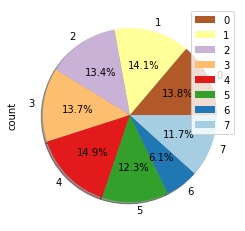

In [44]:
puser_count.plot(kind='pie',x='user_name',y='count',colormap='Paired_r', autopct='%1.1f%%', shadow=True)


<AxesSubplot:xlabel='user_name'>

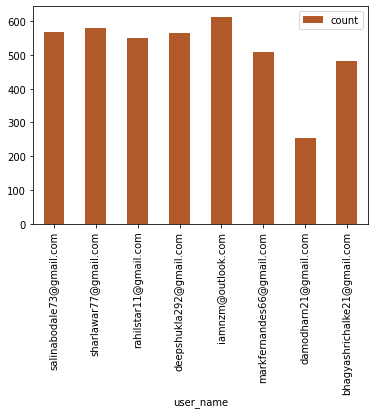

In [47]:
puser_count.plot(kind='bar',x='user_name',y='count',colormap='Paired_r')


Plotting highest averahe work hours


In [63]:
#converting to pandas DF
p_avg = hrs_df.toPandas()

<AxesSubplot:ylabel='avg_hrs'>

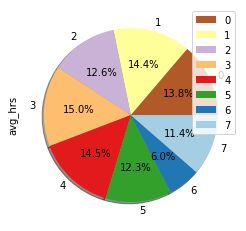

In [64]:
p_avg.plot(kind='pie',x='user_name',y='avg_hrs',colormap='Paired_r', autopct='%1.1f%%', shadow=True)


In [76]:
username= p_avg['user_name']
avg_sec=p_avg['avg_hrs']

<AxesSubplot:xlabel='user_name'>

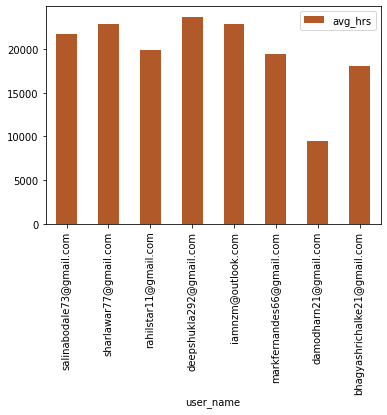

In [80]:
p_avg.plot(kind='bar',x='user_name',y='avg_hrs', colormap='Paired_r')


Plot for idle 

In [81]:
idle = idle_count.toPandas()

<AxesSubplot:ylabel='count'>

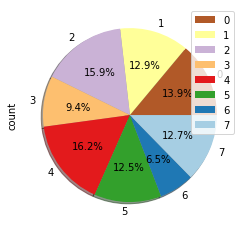

In [83]:
idle.plot(kind='pie',x='user_name',y='count',colormap='Paired_r', autopct='%1.1f%%', shadow=True)


<AxesSubplot:xlabel='user_name'>

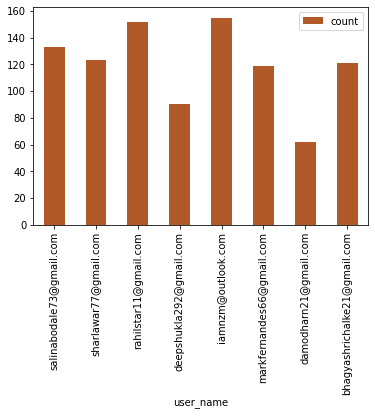

In [84]:
idle.plot(kind='bar',x='user_name',y='count', colormap='Paired_r')
